## Importy

In [17]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

## Problem

Postawionym problemem jest wykorzystanie sieci neuronowych do stworzenia modelu regresji przewidującego ocenę śmieszności żartów na podstawie zbioru Jester.

## Wczytanie danych

In [18]:
def extract_jokes_from_html(folder_path):
    jokes = []
    for i in range(1, 101):
        file_path = os.path.join(folder_path, f'init{i}.html')
        with open(file_path, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')

            # Znajdź wszystkie elementy zawierające tekst
            texts = soup.find_all(string=True)

            # Filtruj tylko te teksty, które są częścią żartu
            joke = []
            inside_joke = False
            for text in texts:
                if "begin of joke" in text:
                    inside_joke = True
                elif "end of joke" in text:
                    inside_joke = False
                elif inside_joke:
                    clean_text = text.strip().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace("\'", "`")
                    joke.append(clean_text)

            jokes.append(" ".join(joke))
    return jokes


folder_path = 'jokes'
jokes = extract_jokes_from_html(folder_path)

In [19]:
def load_ratings(file_path):
    df = pd.read_excel(file_path, header=None)
    return df

file_path = 'jester-data-1.xls'
ratings = load_ratings(file_path)

## Analiza danych

In [20]:
print(jokes)

['A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer`s disease". The man replies "Well,thank God I don`t have cancer!"', 'This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him. "What could they possibly have said to make you move out?" "They told me that you were a pedophile." He replied, "That`s an awfully big word for a ten year old."', 'Q. What`s 200 feet long and has 4 teeth? A. The front row at a Willie Nelson Concert.', 'Q. What`s the difference between a man and a toilet? A. A toilet doesn`t follow you around after you use it.', 'Q. What`s O. J. Simpson`s Internet address? A. Slash, slash, backslash, slash, slash, escape.', 'Bill & Hillary are on a trip back to Arkansas. They`re almost out of gas, so Bill pulls into a service station on the outskirts of town. The attendant runs 

In [21]:
display(ratings)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,100,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,91,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,39,99.00,99.00,99.00,99.00,-7.77,99.00,6.70,-6.75,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
24981,37,99.00,99.00,99.00,99.00,-9.71,99.00,4.56,-8.30,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00


Pierwsza kolumna zawiera liczbę żartów, które ocenił użytkownik. Oceny są w skali od -10.0 do 10.0. Jeżeli użytkownik nie wystawił oceny wpisana jest wartość 99. Niestety wartości wydają się bardzo losowe. Na przykład w 1 wierszy 6 kolumny may wartość -9.66, a w kolejnym wierszu 9.27, a więc całkowicie przeciwna ocena.

## Przygotowanie danych

Zamieniamy teksty żartów na macierze wartości za pomocą modelu językowego Bert.

In [22]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-cased')

embeddings = model.encode(jokes)

print(embeddings)
print(len(embeddings))

No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
D:\Sztuczna inteligencja\Lista5\venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[[ 0.22627665  0.08958738  0.20544173 ...  0.35160983  0.18786928
   0.19827567]
 [ 0.07616243  0.1532522  -0.18702173 ...  0.24419166 -0.0950858
  -0.1363937 ]
 [ 0.01316407  0.03475337 -0.06628502 ...  0.25054377  0.03303232
  -0.18316565]
 ...
 [ 0.10938796 -0.06235369  0.01834033 ...  0.16218281  0.24299237
  -0.12465361]
 [ 0.44622514 -0.00099882  0.04281776 ...  0.15277788  0.27113077
   0.08587256]
 [-0.12652954 -0.35098827  0.14295383 ...  0.30620828 -0.12334433
  -0.00129424]]
100


Jako, że interesuje mnie średnia ocen, zastępuję liczby 99 polem NaN aby wykluczyć je z wyliczanej średniej.

In [23]:
ratings.replace(99, np.nan, inplace=True)

mean_ratings = ratings.iloc[:, 1:].mean(axis=0, skipna=True)

y = mean_ratings.values

print(y)
print(len(y))

[ 0.9045733   0.20845963  0.31657433 -1.44911392  0.40355647  1.59444716
 -0.42966248 -0.6240851  -0.55703085  1.30123056  1.80579671  1.44929001
 -1.76288179  1.39633444 -1.70620131 -3.10481802 -1.11514131 -0.63510349
  0.15422692 -0.9339968   2.09562578  0.86866188  0.10919233 -1.68741986
  0.38237269  1.286232    3.18982131  1.51882993  2.97245528 -0.43649274
  2.19894346  3.15598765 -1.36864763  0.85949404  3.00635059  3.3125003
 -1.36398673  1.30047861  1.06733709  0.9986347  -0.32049981  1.96687533
 -0.9248558  -2.11189096  1.10861618  1.50023153  1.55953464  1.82588444
  2.77129783  3.6650849  -0.73165255 -0.13312101  2.93946338  2.73569722
  0.50573123  1.76464673 -1.99066362 -3.83387964 -0.57801048 -0.32539447
  2.45918041  2.97602061  0.24699812 -0.6679376   2.27381956  2.54153834
 -0.86386783  2.63913152  2.55946259  0.4184052  -0.68749414  2.7573887
  1.08249188 -1.55354754 -0.27071534  2.5200474   0.71539244  1.75189669
  0.0916674   1.12207447  1.83656186  0.90271811  2.0

Obie tablice mają długość 100, a więc wszystko się zgadza.

## Podział danych na zbiory

In [24]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

## Trenowanie modelu

In [25]:
def regression (solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.001, random_state=42, epochs=200, hidden_layer_sizes=100):
    mlp = MLPRegressor(solver=solver, alpha=alpha, learning_rate=learning_rate, learning_rate_init=learning_rate_init, random_state=random_state, hidden_layer_sizes=hidden_layer_sizes)

    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        mlp.partial_fit(X_train, y_train)
        train_loss.append(mlp.loss_)
        y_val_pred = mlp.predict(X_test)
        val_loss.append(mean_squared_error(y_test, y_val_pred))

    plt.plot(range(epochs), train_loss, label='Train Loss')
    plt.plot(range(epochs), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss over Epochs')
    plt.show()

    train_score = mlp.score(X_train, y_train)
    test_score = mlp.score(X_test, y_test)

    return train_score, test_score

### Podstawowe parametry

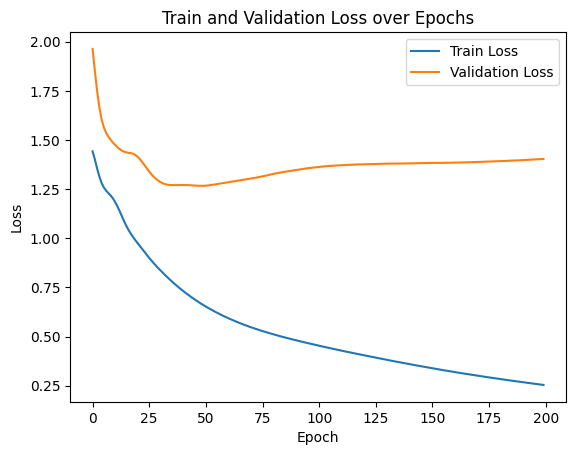

Train score: 0.8028188827316062
Test score: 0.10512205796728868


In [26]:
train_score, test_score = regression()

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Z podstawowymi parametrami model radzi sobie dobrze jedynie na danych treningowych. Dla danych walidacyjnych uzyskaliśmy wynik ujemny co oznacza, że model radzi sobie nawet gorzej niż model który za każdym razem miałby bezpiecznie wskazywać średnią wartość ze wszystkich ocen.

### Zmiana tempa uczenia

Constant slow


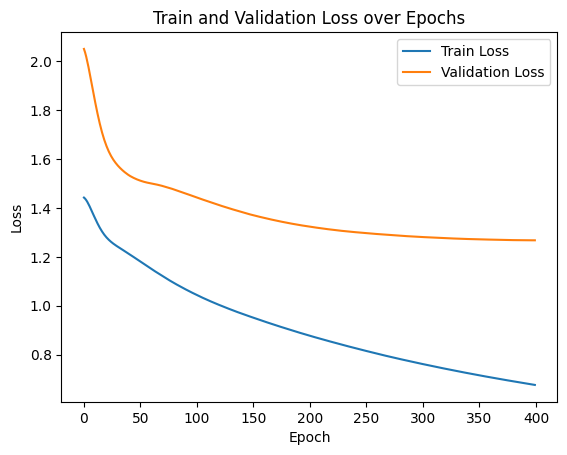

Constant medium


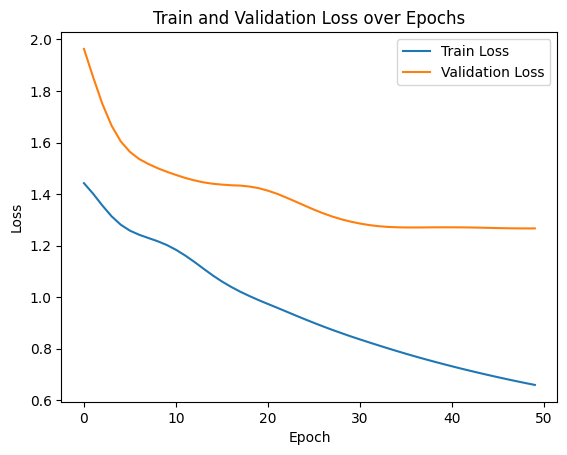

Constant fast


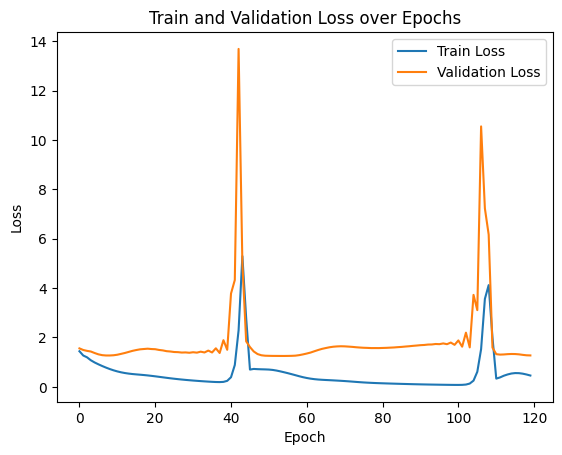

Invscaling


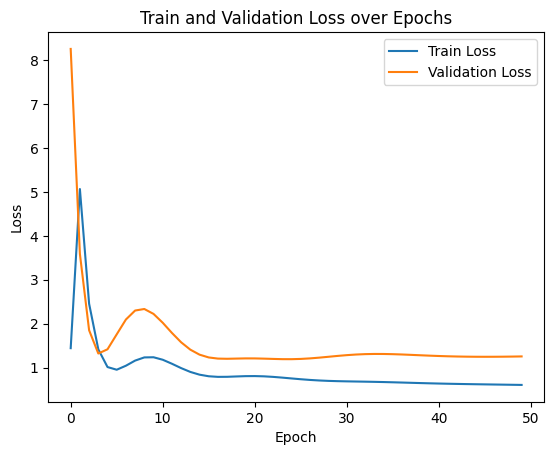

Adaptive


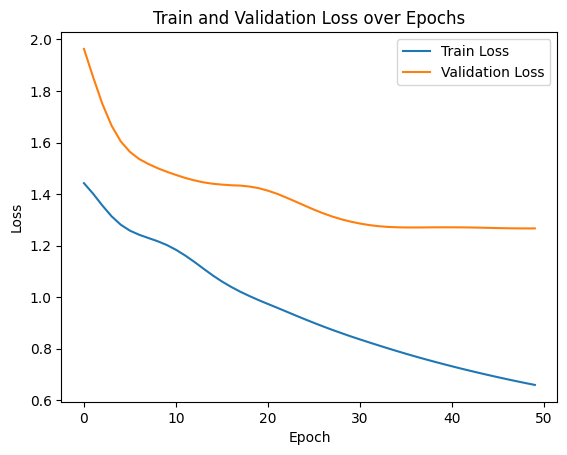

Constant slow - train score: 0.4721808901155451 	 test score: 0.191863141551059
Constant medium - train score: 0.49016332974702403 	 test score: 0.19232313920298494
Constant fast - train score: 0.6778682145713357 	 test score: 0.18873285057455758
Invscaling - train score: 0.529344662766177 	 test score: 0.20029763820170754
Adaptive - train score: 0.49016332974702403 	 test score: 0.19232313920298494


In [27]:
print("Constant slow")
train_score11, test_score11 = regression(epochs=400, learning_rate='constant', learning_rate_init=0.0001)
print("Constant medium")
train_score12, test_score12 = regression(epochs=50, learning_rate='constant', learning_rate_init=0.001)
print("Constant fast")
train_score13, test_score13 = regression(epochs=120, learning_rate='constant', learning_rate_init=0.01)
print("Invscaling")
train_score2, test_score2 = regression(epochs=50, learning_rate='invscaling', learning_rate_init=0.05)
print("Adaptive")
train_score3, test_score3 = regression(epochs=50, learning_rate='adaptive', learning_rate_init=0.001)

print(f"Constant slow - train score: {train_score11} \t test score: {test_score11}")
print(f"Constant medium - train score: {train_score12} \t test score: {test_score12}")
print(f"Constant fast - train score: {train_score13} \t test score: {test_score13}")

print(f"Invscaling - train score: {train_score2} \t test score: {test_score2}")
print(f"Adaptive - train score: {train_score3} \t test score: {test_score3}")

Im większe tempo uczenia tym większe tworzą się nagłe skoki w funkcji kosztu. Przy wolnym, stałym tempie uczenia jako jedynym opłacało się trenować model dłużej niż 50 epok. Dopiero po 400 epokach funkcja kosztu przestała maleć, a zaczęła stale rosnąć. Tempo zmienne takie 'invscaling' czyli zwiększające się wraz upływem czasu dało najlepsze wyniki przy odpowiednim ustawieniu parametrów. Widzimy, że uzyskane wyniki już są lepsze od poprzednich - spadła punktacja dla zbioru treningowego ale wzrosła dla walidacyjnego, a więc model nie jest już aż tak przetrenowany.

### Zmiana rozmiaru modelu

Small model


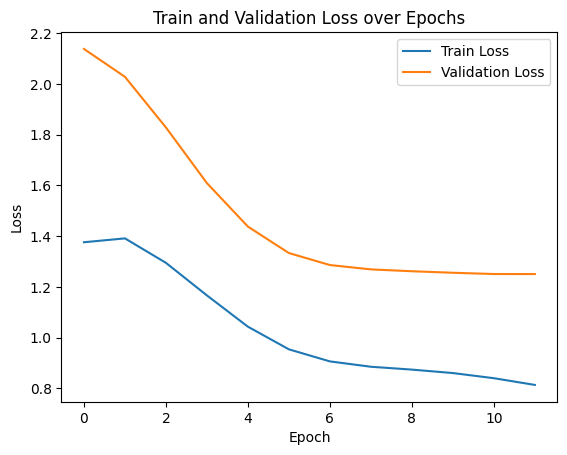

Medium model


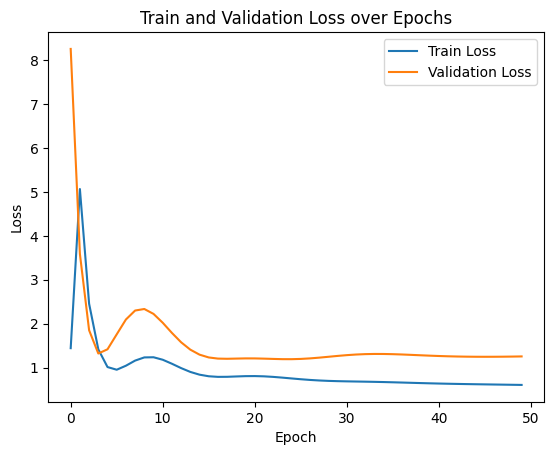

Large model


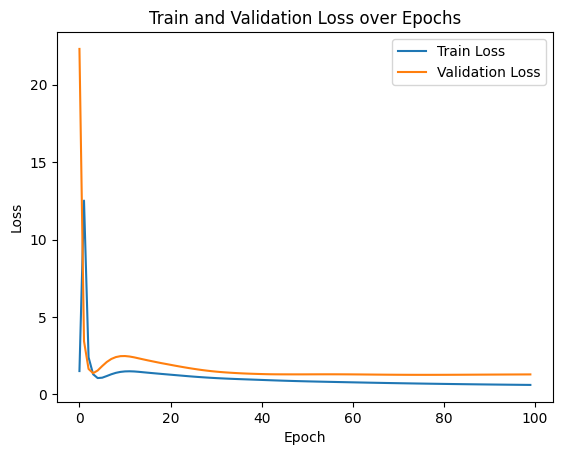

Small model - train score: 0.386387841943576 	 test score: 0.20263896584627594
Medium model - train score: 0.529344662766177 	 test score: 0.20029763820170754
Large model - train score: 0.5214438497702056 	 test score: 0.17528152523418705


In [28]:
print("Small model")
train_score1, test_score1 = regression(epochs=12, learning_rate='invscaling', learning_rate_init=0.05, hidden_layer_sizes=50)
print("Medium model")
train_score2, test_score2 = regression(epochs=50, learning_rate='invscaling', learning_rate_init=0.05, hidden_layer_sizes=100)
print("Large model")
train_score3, test_score3 = regression(epochs=100, learning_rate='invscaling', learning_rate_init=0.05, hidden_layer_sizes=200)

print(f"Small model - train score: {train_score1} \t test score: {test_score1}")
print(f"Medium model - train score: {train_score2} \t test score: {test_score2}")
print(f"Large model - train score: {train_score3} \t test score: {test_score3}")

Zasadniczo zmiana liczby neuronów nie poprawiła jakości modelu. W przypadku małej liczby neuronów doszło do sytuacji gdzie model miał najmniejszą koszt na danych walidacyjnych na 12 epoce. Jednak w tym miejscu wynik dla danych treningowych jeszcze nie jest tak niski jak mógłby być. Im większa liczba neuronów tym większy koszt na starcie nauki. Potem jednak wyniki zbiegają się do podobnego poziomu.

### Testowanie modelu własnymi dowcipami

Przygotowałem dwa dowcipy, które zostały opowiedziane w trakcie streamu Adina Rossa w grze Comedy Night. Pierwszy żart zarówno według mnie jak i komentujących jest śmieszniejszy i mocniejszy od drugiego. Sprawdźmy czy tak samo uzna model. Do tego dopisałem jeszcze trzeci tekst który jest powtarzaniem jednego wulgarnego słowa i w teorii powinien być uznany za najmniej śmieszny.

In [29]:
new_jokes = ["What is the best part of fucking twenty eight year olds? There are twenty of them.", "How are blacks and blinds similar? They both never seen their parents.", "Shit shit shit shit shit shit."]

x_test2 = model.encode(new_jokes)

print(x_test2)

[[ 0.23739126  0.17016527 -0.282068   ...  0.22390556  0.11050854
   0.08879758]
 [ 0.5204387   0.02477654 -0.01180703 ...  0.15513974 -0.06487856
   0.07141127]
 [ 0.01691127  0.33794245  0.6011471  ... -0.09443711  0.456293
   0.45192337]]


In [30]:
mlp1 = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='invscaling', learning_rate_init=0.05, max_iter=50, random_state=42, hidden_layer_sizes=100)
mlp1.fit(X_train, y_train)
y_pred1 = mlp1.predict(x_test2)

mlp2 = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='invscaling', learning_rate_init=0.05, max_iter=5000, random_state=42, hidden_layer_sizes=100)
mlp2.fit(X_train, y_train)
y_pred2 = mlp2.predict(x_test2)

print(y_pred1)
print(y_pred2)

D:\Sztuczna inteligencja\Lista5\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[-0.5122762  -0.39220923  0.08308642]
[-0.38677183 -1.1122495  -0.7004566 ]


Wyniki są całkiem ciekawe. Przy ustawieniu maksymalnej liczby iteracji na 50 czyli tyle ile według wykresów powinno dać najlepsze wyniki dla zbioru walidacyjnego uzyskaliśmy całkowicie odwrotne wyniki - żart według mnie najśmieszniejszy uzyskał najniższą ocenę o powtarzane jedno słowo jako jedyne uzyskało ocenę pozytywną. Jednak kiedy pozwoliłem modelowi na większą liczbę iteracji, która według niego pozwoliła na osiągnięcie zbieżności, uzyskałem wyniki z którymi prędzej bym się zgodził. Należy pamiętać że żarty często polegają na grze słów, której model nauczony jedynie na 100 tekstach nie będzie rozumiał. Nie spodziewałem się rewelacyjnych wyników i takie właśnie uzyskałem.